In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf  # 导入TensorFlow库，用于构建和训练机器学习模型
import shap # 导入SHAP库，用于解释模型预测
import seaborn as sns
import matplotlib.font_manager as fm

from multiprocessing.spawn import import_main_path
from sklearn.preprocessing import MinMaxScaler
shap.initjs()   # 初始化SHAP的JavaScript环境
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense  # 导入Input和Dense，用于构建网络层
from tensorflow.keras import regularizers  # 导入regularizers，用于添加正则化
from tensorflow.keras.callbacks import EarlyStopping  # 导入EarlyStopping，用于提前停止训练
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.image as mpimg
# mpl.rcParams['font.family'] = 'SimHei'  # 设置字体为黑体
# plt.rcParams['axes.unicode_minus'] = False # 设置坐标轴负号
# plt.rcParams['font.size'] = 23  # 设置字体大小
# plt.rcParams['figure.dpi'] = 3000  # 设置图像分辨率

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
 
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

In [2]:
# 加载 CSV 文件
data = pd.read_csv("../data/water/全国地表水/2021年/2021_06_17_13h09m_国家地表水水质自动监测系统检测数据.csv", encoding="gbk").dropna()  # 读取CSV文件并删除缺失值
# data['Timestamp'] = pd.to_datetime(data['监测时间'], format = '%Y-%m-%d %H:%M')
data.drop(['省份','流域','断面名称','监测时间','水质类别','站点情况'],axis = 1,inplace= True)  # 删除不需要的列
# data = data.reset_index(drop=True) # 重置索引
# data = data[]
# data = data.T
# data = data.iloc[3:]
# 将非数值数据转换为 NaN
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 处理缺失值
data.fillna(0, inplace=True)  # 用 0 填充缺失值，或者你可以选择其他合适的值

# 显示数据类型
print(data.dtypes)


水温(℃)           float64
pH(无量纲)         float64
溶解氧(mg/L)       float64
电导率(μS/cm)      float64
浊度(NTU)         float64
高锰酸盐指数(mg/L)    float64
氨氮(mg/L)        float64
总磷(mg/L)        float64
总氮(mg/L)        float64
叶绿素α(mg/L)      float64
藻密度(cells/L)    float64
dtype: object


In [3]:
# 处理缺失值
data.fillna(method='ffill', inplace=True)

# 删除重复行
data.drop_duplicates(inplace=True)

# 显示前10行数据
print(data.head())

# 查看数据的基本信息
data.info()
# data.head()

   水温(℃)  pH(无量纲)  溶解氧(mg/L)  电导率(μS/cm)  浊度(NTU)  高锰酸盐指数(mg/L)  氨氮(mg/L)  \
0   25.3     8.24      10.33       333.3     22.9          2.22     0.099   
1   26.0     8.71      11.35      1259.0      5.5          4.01     0.051   
2   25.7     7.36       7.08       888.6     13.7          5.24     0.401   
4   24.8     7.74       4.80      1146.0      7.1          4.28     0.137   
5   26.2     8.54       8.92      1188.2      5.4          6.31     0.139   

   总磷(mg/L)  总氮(mg/L)  叶绿素α(mg/L)  藻密度(cells/L)  
0     0.025      2.54         0.0           0.0  
1     0.034      2.30         0.0           0.0  
2     0.137      5.01         0.0           0.0  
4     0.084      9.50         0.0           0.0  
5     0.046      0.91         0.0           0.0  
<class 'pandas.core.frame.DataFrame'>
Index: 1571 entries, 0 to 1661
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   水温(℃)         1571 non-null   float64
 1   p

C:\Users\admin\AppData\Local\Temp\ipykernel_15660\341957695.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


In [4]:
# # 将日期转换为日期时间格式
# data['监测时间'] = pd.to_datetime(data['监测时间'], format='%Y/%m/%d %H:%M')
# # data = data[data['hour'].between(0, 23)]  # 确保小时在0到23之间

# 统计每列中空值的数量
data.isnull().sum()

水温(℃)           0
pH(无量纲)         0
溶解氧(mg/L)       0
电导率(μS/cm)      0
浊度(NTU)         0
高锰酸盐指数(mg/L)    0
氨氮(mg/L)        0
总磷(mg/L)        0
总氮(mg/L)        0
叶绿素α(mg/L)      0
藻密度(cells/L)    0
dtype: int64

In [5]:
# 查找系统中的中文字体
zh_fonts = [f.name for f in fm.fontManager.ttflist if 'CN' in f.name or 'Kai' in f.name or 'Hei' in f.name]

# 如果找到了可用的中文字体，使用第一个找到的
if zh_fonts:
    plt.rcParams['font.sans-serif'] = [zh_fonts[1]]  # 自动选择系统中的可用中文字体
else:
    print("未找到中文字体，确保系统中安装了中文字体。")

plt.rcParams['axes.unicode_minus'] = False  # 解决坐标轴负号显示问题

In [6]:
# 特征标准化
data_norm = (data - data.mean()) / data.std()  # 标准化数据
# data_norm = data_norm.iloc[:, 1:]
data_norm = data_norm.astype('float32')  # 转换数据类型
start_sclice=540  # 定义切片起始位置
# 构建自编码器模型
data_norm_train = pd.concat([data_norm[:start_sclice],data_norm[start_sclice+300:]],ignore_index=True) # 训练数据
data_norm_test = data_norm[start_sclice:start_sclice+300]  # 测试数据
# data_norm_train,data_norm_test = train_test_split(data_norm,test_size=0.2)

In [7]:
input_dim = data_norm.shape[1]  # 输入维度
encoding_dim = 5  # 编码维度
# 构建编码器和解码器
input_layer = tf.keras.layers.Input(shape=(input_dim,)) # 创建输入层，接收形状为 (input_dim,) 的输入数据
# 创建第一个全连接层作为编码器的一部分，使用 8 个神经元，ReLU 激活函数，并添加 L1 正则化项（权重衰减）来防止过拟合
encoder = Dense(8, activation="relu",
                activity_regularizer=regularizers.l1(10e-7))(input_layer)

encoder = Dense(5, activation="relu",
                kernel_regularizer=regularizers.l2(10e-7))(encoder)

encoder = Dense(3, activation='relu',
                kernel_regularizer=regularizers.l2(10e-7))(encoder)
# 创建第一个全连接层作为解码器的一部分，使用 5 个神经元，ReLU 激活函数，并添加 L2 正则化项来防止过拟合
decoder = Dense(5, activation='relu',
                kernel_regularizer=regularizers.l2(10e-7))(encoder)
decoder = Dense(8, activation='relu',
                kernel_regularizer=regularizers.l2(10e-7))(decoder)
# 创建输出层，使用与输入层相同数量的神经元，Sigmoid 激活函数，并添加 L2 正则化项来防止过拟合
# Sigmoid 激活函数用于将输出值限制在 0 和 1 之间，适用于将输出值解释为概率
decoder = Dense(input_dim, activation='sigmoid',
                kernel_regularizer=regularizers.l2(10e-7))(decoder)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)  # 构建模型
autoencoder.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['mse'])  # 编译模型
# 训练自编码器模型
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1) # 定义提前停止的参数
history = autoencoder.fit(data_norm_train,data_norm_train, epochs=50, batch_size=11, shuffle=True, validation_data=(data_norm_train, data_norm_train), callbacks=[earlystopper])
# 使用自编码器模型对数据进行预测
reconstructed_data = autoencoder.predict(data_norm_test)

Epoch 1/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.3375 - mse: 1.3374 - val_loss: 1.2683 - val_mse: 1.2683
Epoch 2/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3588 - mse: 1.3587 - val_loss: 1.2073 - val_mse: 1.2072
Epoch 3/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2851 - mse: 1.2850 - val_loss: 1.1400 - val_mse: 1.1400
Epoch 4/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9741 - mse: 0.9741 - val_loss: 1.0808 - val_mse: 1.0807
Epoch 5/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0171 - mse: 1.0170 - val_loss: 1.0247 - val_mse: 1.0247
Epoch 6/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9576 - mse: 0.9576 - val_loss: 0.9737 - val_mse: 0.9736
Epoch 7/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9383 - mse: 0.9382 - val_loss: 0.9473 - val_mse: 0.9472
Epoch 8/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9276 - mse: 0.9275 - val_loss: 0.9304 - val_mse: 0.9303
Epoch 9/50
116/116 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

  0%|          | 0/9 [00:00<?, ?it/s]

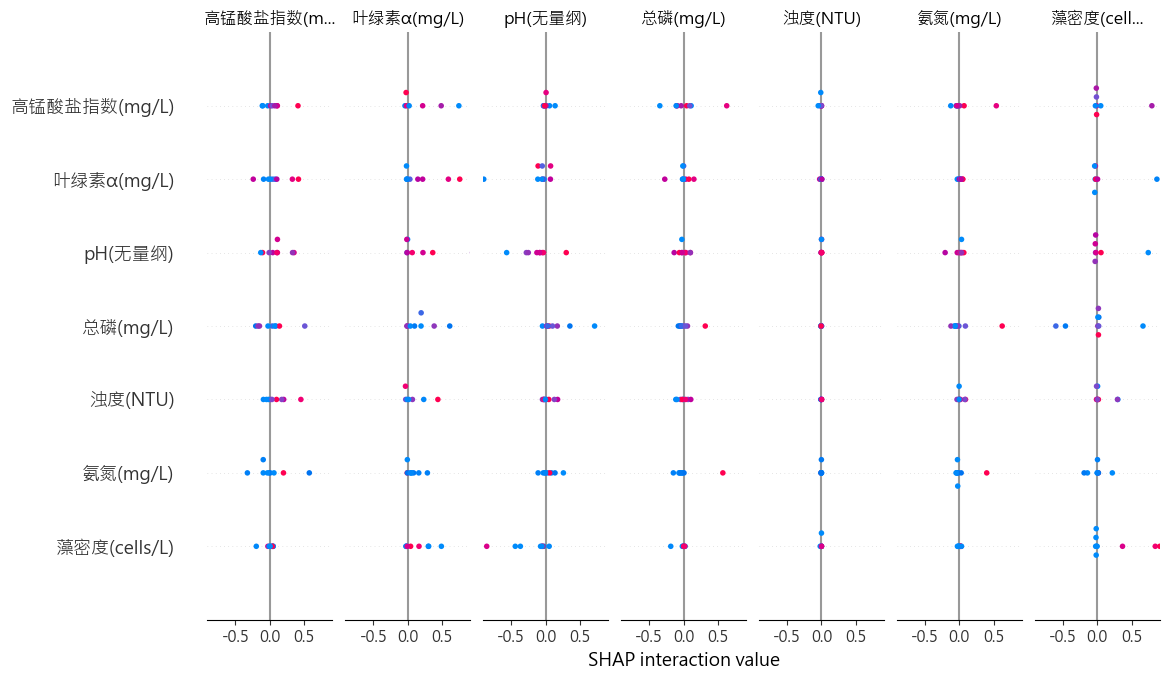

[  4  22  93 123 226 236 240 246 281]


In [8]:
# 计算重构误差
mse = np.mean(np.power(data_norm_test - reconstructed_data, 2), axis=1)
# 使用SHAP库计算SHAP值
background_set = shap.sample(data_norm,100) # 从数据中采样作为背景集
explainer = shap.KernelExplainer(autoencoder,background_set,n_jobs = -1)    # 创建解释器
threshold = np.percentile(mse, 97)  # 定义异常阈值
anomalies = np.where(mse > threshold)[0]  # 找到异常数据的索引
need2explained = data_norm.iloc[[start_sclice + i for i in anomalies]]  # 获取异常数据
shap_values = explainer.shap_values(need2explained)
# 可视化SHAP值
shap.summary_plot(shap_values, need2explained)
nshap_values = np.array(shap_values)
# 结合SHAP值和重构误差来检测异常值
print(anomalies)

In [9]:
data.iloc[[start_sclice + i for i in anomalies]]


,水温(℃),pH(无量纲),溶解氧(mg/L),电导率(μS/cm),浊度(NTU),高锰酸盐指数(mg/L),氨氮(mg/L),总磷(mg/L),总氮(mg/L),叶绿素α(mg/L),藻密度(cells/L)
571,26.2,7.14,0.85,388.8,26.2,4.89,0.170,0.053,1.19,0.065,0.0
589,25.9,7.50,5.65,668.3,69.8,4.82,0.244,0.074,1.00,0.033,61714160.0
661,37.6,6.01,6.78,0.4,0.0,2.68,0.025,0.012,1.34,0.003,52530280.0
691,32.6,7.07,6.93,326.7,1.5,2.75,0.052,0.139,16.15,0.000,0.0
804,24.3,7.47,1.93,8297.9,53.2,7.37,0.308,0.100,10.64,0.000,0.0
814,27.7,7.52,6.62,1273.3,39.4,4.06,0.170,0.134,0.91,0.043,0.0
818,26.8,7.77,5.08,966.3,28.2,5.51,0.080,0.042,0.86,0.015,79687500.0
824,23.4,7.33,2.78,495.7,23.9,5.85,2.788,0.390,7.10,0.000,0.0
861,26.5,8.10,7.93,471.3,2.2,2.59,0.025,0.009,0.65,0.035,1681510.0


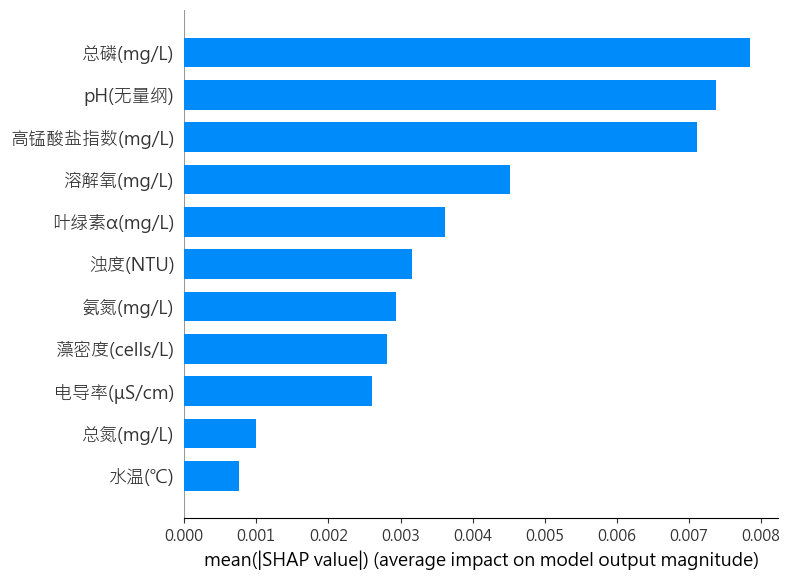

In [10]:
shap.summary_plot(nshap_values[:,0,:],need2explained,plot_type='bar')

In [11]:
# 将异常数据保存到Excel文件
ad_result =data.iloc[[start_sclice + i for i in anomalies]]
ad_result.to_excel('test1.xlsx',sheet_name='Sheet1',index=False)

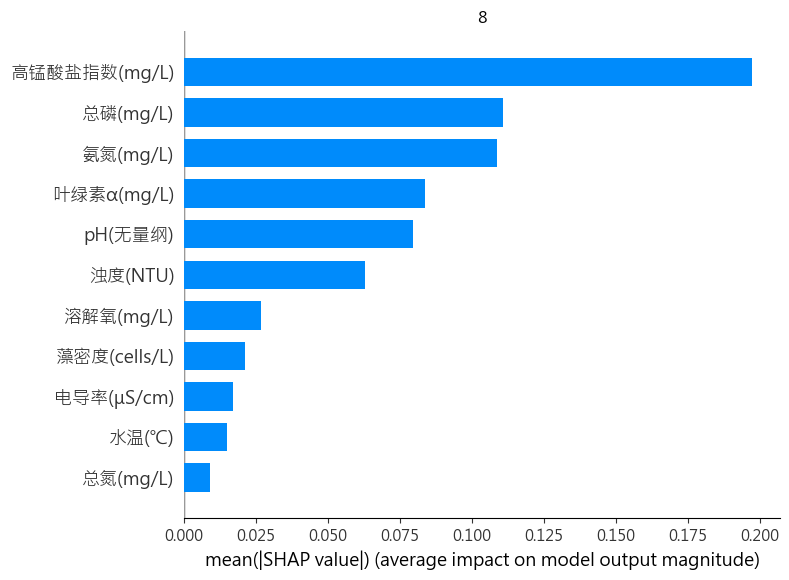

In [12]:
for i in range(8):
    plt.title(f"{i+1}")
    # shap.summary_plot(nshap_values[:,i,:],need2explained,plot_type='bar',show = False,title="SHAP_value",auto_size_plot=None)
    shap.summary_plot(nshap_values[:,i,:],need2explained,plot_type='bar',show = False,title="SHAP_value")
    plt.savefig(f'image_{i}.svg',bbox_inches='tight')

In [13]:
# images = []
# for i in range(8):
#     img = plt.imread(f"image_{i}.svg")
#     images.append(img)
# # 定义画布和子图
# fig, axs = plt.subplots(nrows=5,ncols=2,figsize=(1,2))
# plt.subplots_adjust(wspace=0.001,hspace=0.001)
# # 在子图中画出每张图片
# for i, ax in enumerate(axs.flat):
#     if i < len(images):
#         ax.imshow(images[i])
#         # ax.text(0.5, -0.1, f"{i+1}", transform=ax.transAxes,
#         #         fontsize=12, ha='center')
#     ax.axis('off')
# plt.tight_layout
# plt.savefig("most_8.svg",format="svg")
# fig, ax = plt.subplots(figsize=(8, 8))
# ax.plot(history.history['loss'], 'b', label='训练曲线', linewidth=3)
# ax.plot(history.history['val_loss'], 'r', label='测试曲线', linewidth=3)
# # ax.set_title('Model loss', fontsize=16)
# ax.set_ylabel('损失率',fontsize=14)
# ax.set_xlabel('迭代次数'fontsize=14)
# ax.legend(loc='upper right',fontsize=12)
# plt.savefig(r'F:\loss.png')
# plt.show()
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()